<a href="https://colab.research.google.com/github/amifunny/Deep-Learning-Notebook/blob/master/faceNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
"""
  In this Notebook , we implement a "FACENET" MODEL widely used for face recogniton.

  Paper - 'https://arxiv.org/abs/1503.03832'

  Data - Bollywood Celeb Datset 
         and LFW - labeled faces in wild dataset

"""

In [0]:
api_token = {"username":"<your_user_name_here>","key":"<your_key_here>"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [0]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

In [0]:
%tensorflow_version 2.x
import tensorflow as tf

import numpy as np
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from PIL import Image
import kaggle

import random

In [0]:
!kaggle datasets download -d havingfun/100-bollywood-celebrity-faces

In [0]:
!unzip 100-bollywood-celebrity-faces.zip

In [0]:
#  BOLLY WOOD SET
import os
import random

batch_size = 8
nob = 120
total_trips = batch_size*nob

def get_data():
  Anchor = []
  Positive = []
  Negative = []

  for i in range(total_trips):

      try:
        f_no = 'faces'+str(random.randrange(3))

        noc = os.listdir('/content/'+f_no)
        p_categ_no = random.randrange(len(noc))
        n_categ_no = random.choice( list(range(0,p_categ_no)) + list(range(p_categ_no+1, len(noc))))

        p_categ_path = '/content/'+f_no+'/'+noc[p_categ_no]
        p_all_img = os.listdir(p_categ_path)
        nop = len(p_all_img)

        while(True):
          a_no = random.randrange( nop )
          p_no = random.choice( list(range(0,a_no)) + list(range(a_no+1, nop )) )
          if (".jpg" in p_all_img[a_no] or ".jpeg" in p_all_img[a_no]) and (".jpg" in p_all_img[p_no] or ".jpeg" in p_all_img[p_no]):
              # print(p_all_img[a_no])
              break
          else:
              continue

        n_categ_path = '/content/'+f_no+'/'+noc[n_categ_no]

        n_all_img = os.listdir(n_categ_path)
        while(True):
          n_no = random.randrange( len(n_all_img) )
          if (".jpg" in n_all_img[n_no] or ".jpeg" in n_all_img[n_no]):
              # print(n_all_img[n_no])
              break
          else:
              continue

        a_img = p_categ_path+'/'+p_all_img[a_no]
        p_img = p_categ_path+'/'+p_all_img[p_no]
        n_img = n_categ_path+'/'+n_all_img[n_no]

        temp_arr = []
        for each_img in [a_img,p_img,n_img]:
            
            image = Image.open(each_img)
            image = image.resize((224,224))
            arr = np.array(image)/255.0
            arr = arr[:,:,:3]
            temp_arr.append(arr)
        
        Anchor.append(temp_arr[0])
        Positive.append(temp_arr[1])
        Negative.append(temp_arr[2])
      
      except :
        continue 

  return Anchor,Positive,Negative


In [0]:
!wget 'http://vis-www.cs.umass.edu/lfw/lfw.tgz'

In [0]:
!tar -xvf 'lfw.tgz'

In [0]:
import os
all_categs = os.listdir('/content/lfw')
many_img_categ = []
tota = 0
peta = 0
for each_categ in all_categs:

    noi = len(os.listdir('/content/lfw/'+each_categ))
    tota = tota+noi
    if noi>1 and noi<=34:
      peta = peta+noi
      many_img_categ.append((each_categ,noi))

print(tota)
print(peta)
print(many_img_categ)
print(len(many_img_categ))


In [0]:
noc = len(many_img_categ)
noft = 1000

trip_categ = 0

# this dataset can also be used
# but in training loop we have only called "get_data()" ie bollywood dataset
# LFW dataset
def data_stroke():

  Anchor = []
  Positive = []
  Negative = []

  trip_num = 0
  global trip_categ

  while(trip_num<noft):

    p_categ_no = trip_categ

    p_categ = many_img_categ[p_categ_no][0]
    noi_in_p = many_img_categ[p_categ_no][1]

    no_each_trip = 0

    for i in range(noi_in_p):

      all_p_img = os.listdir('/content/lfw/'+p_categ)
      a_img = all_p_img[ i ]                              
      p_img = all_p_img[ (i+1)%noi_in_p ]

      n_categ_no = random.choice( list(range(0,p_categ_no)) + list(range(p_categ_no+1, noc )))
      n_categ = many_img_categ[n_categ_no][0]
      all_n_img = os.listdir('/content/lfw/'+n_categ)
      n_img_no = random.randrange(len(all_n_img))
      
      n_img = all_n_img[n_img_no]

      no_each_trip = no_each_trip+1

      a_img = '/content/lfw/'+p_categ+'/'+a_img
      p_img = '/content/lfw/'+p_categ+'/'+p_img
      n_img = '/content/lfw/'+n_categ+'/'+n_img

      temp_arr = []
      for each_img in [a_img,p_img,n_img]:
          
          image = Image.open(each_img)
          image = image.resize((224,224))
          arr = np.array(image)/255.0
          arr = arr[:,:,:3]
          temp_arr.append(arr)
      
      Anchor.append(temp_arr[0])
      Positive.append(temp_arr[1])
      Negative.append(temp_arr[2])

    trip_num = trip_num + no_each_trip
    trip_categ = trip_categ+1

  return Anchor,Positive,Negative


In [0]:
Anchor,Positive,Negative = data_stroke()

In [0]:
print(len(Anchor))
print(len(Positive))
print(len(Negative))

In [0]:
# View any triplet
i=99
for img in [Anchor[i],Positive[i],Negative[i]]:
  show = plt.imshow(img)
  plt.show()

In [0]:
perm_index = np.random.permutation(len(Anchor))
shuffle_A = []
shuffle_P = []
shuffle_N = []

for i in perm_index:
    shuffle_A.append(Anchor[i])
    shuffle_P.append(Positive[i])
    shuffle_N.append(Negative[i])


In [0]:
i = 100

show = plt.imshow(shuffle_A[i])
plt.show()

show = plt.imshow(shuffle_P[i])
plt.show()

show = plt.imshow(shuffle_N[i])
plt.show()  

In [0]:
conv_constraint = tf.keras.constraints.MinMaxNorm(
    min_value=-2.0, max_value=2.0, rate=1.0, axis=[0, 1, 2]
)

dense_constraint = tf.keras.constraints.MinMaxNorm(
    min_value=-2.0, max_value=2.0, rate=1.0, axis=0
)

initial = tf.keras.initializers.he_normal(seed=15)

inputs = tf.keras.layers.Input((224,224,3))

out = tf.keras.layers.Conv2D(64,(3,3),padding='SAME',kernel_constraint=conv_constraint,activation='relu')(inputs)
out = tf.keras.layers.Conv2D(64,(3,3),padding='SAME',kernel_constraint=conv_constraint,activation='relu')(out)
out = tf.keras.layers.MaxPool2D((2,2))(out)
out = tf.keras.layers.Conv2D(128,(3,3),padding='SAME',kernel_constraint=conv_constraint,activation='relu')(out)
out = tf.keras.layers.Conv2D(128,(3,3),padding='SAME',kernel_constraint=conv_constraint,activation='relu')(out)
out = tf.keras.layers.MaxPool2D((2,2))(out)
out = tf.keras.layers.Conv2D(256,(3,3),padding='SAME',kernel_constraint=conv_constraint,activation='relu')(out)
out = tf.keras.layers.Conv2D(256,(3,3),padding='SAME',kernel_constraint=conv_constraint,activation='relu')(out)
out = tf.keras.layers.Conv2D(256,(3,3),padding='SAME',kernel_constraint=conv_constraint,activation='relu')(out)
out = tf.keras.layers.MaxPool2D((2,2))(out)
out = tf.keras.layers.Conv2D(512,(3,3),padding='SAME',kernel_constraint=conv_constraint,activation='relu')(out)
out = tf.keras.layers.Conv2D(512,(3,3),padding='SAME',kernel_constraint=conv_constraint,activation='relu')(out)
out = tf.keras.layers.Conv2D(512,(3,3),padding='SAME',kernel_constraint=conv_constraint,activation='relu')(out)
out = tf.keras.layers.MaxPool2D((2,2))(out)
out = tf.keras.layers.Conv2D(512,(3,3),padding='SAME',kernel_constraint=conv_constraint,activation='relu')(out)
out = tf.keras.layers.Conv2D(512,(3,3),padding='SAME',kernel_constraint=conv_constraint,activation='relu')(out)
out = tf.keras.layers.Conv2D(512,(3,3),padding='SAME',kernel_constraint=conv_constraint,activation='relu')(out)
out = tf.keras.layers.MaxPool2D((2,2))(out)

out = tf.keras.layers.Flatten()(out)
out = tf.keras.layers.Dense(4096,activation='relu',kernel_constraint=dense_constraint)(out)
out = tf.keras.layers.Dense(512,activation='relu',kernel_constraint=dense_constraint)(out)

out = tf.keras.layers.Dense(128,kernel_constraint=dense_constraint)(out)
outputs = tf.keras.layers.LayerNormalization()(out)

model = 0
model = tf.keras.Model(inputs=inputs,outputs=outputs)
model.summary()

In [0]:
alpha = 10
def loss_func(A,P,N):

    A_and_P = tf.reduce_sum( tf.square(A-P) , 1 )
    A_and_N = tf.reduce_sum( tf.square(A-N) , 1 )

    loss = A_and_P - A_and_N + alpha

    final_loss = tf.math.maximum(loss,0.0)

    final_loss = ( tf.reduce_sum(final_loss))+1e-10

    return A_and_P,A_and_N,final_loss

In [0]:
tf.config.list_logical_devices('GPU')

In [0]:
optimizer = tf.keras.optimizers.Adam(0.0001)
mean = tf.keras.metrics.Mean()

epochs = 2
ctr = 0

with tf.device('/device:GPU:0'):
  
  for e in range(epochs):

    trip_categ = 0

    for stroke in range(4):

      # after evey two loop change data
      if(stroke%2==0):
        Anchor,Positive,Negative = get_data()
        batch_size = 8
        num_of_batches = int(len(Anchor)/batch_size)-1
      print("STROKE {} ===> batches :: {}".format(stroke,num_of_batches))

      mean.reset_states()
      for b in range(num_of_batches):

        batch_A = np.array( Anchor[(b)*batch_size:(b+1)*batch_size] )
        batch_P = np.array( Positive[(b)*batch_size:(b+1)*batch_size] )
        batch_N = np.array( Negative[(b)*batch_size:(b+1)*batch_size] )


        with tf.GradientTape() as tape:

            A_vec = model(batch_A)
            P_vec = model(batch_P)
            N_vec = model(batch_N)

            A_and_P,A_and_N,loss = loss_func(A_vec,P_vec,N_vec)
            mean.update_state(loss)


        grads = tape.gradient( loss , model.trainable_variables )
        optimizer.apply_gradients( zip(grads,model.trainable_variables) )


        if ctr%20==0: 
          print("loss  ::======  ==>   {}".format(mean.result()))  

        ctr = ctr+1
      
      print("Epoch {} ::  ==>   {}".format(e,mean.result()))  


In [0]:
model.save('face_id.h5')
#  OR this
# model.save('saved_model/my_model')

# to download this model
# from google.colab import files
# files.download('face_id.h5')

In [0]:
# TESTING ON MATT DAMON VS MARK WALBERG,
#  Cause model with limited training works perfectly for images i tested on , not on this triplet ; )
!wget -O 'A.jpg' 'https://thumbor.forbes.com/thumbor/fit-in/416x416/filters%3Aformat%28jpg%29/https%3A%2F%2Fspecials-images.forbesimg.com%2Fimageserve%2F577fe96da7ea436bd18c3ef7%2F0x0.jpg%3Fbackground%3D000000%26cropX1%3D0%26cropX2%3D744%26cropY1%3D15%26cropY2%3D759'
!wget -O 'P.jpg' 'https://upload.wikimedia.org/wikipedia/commons/8/83/Matt_Damon_TIFF_2015.jpg'
!wget -O 'N.jpg' 'https://www.gstatic.com/tv/thumb/persons/43431/43431_v9_ba.jpg'

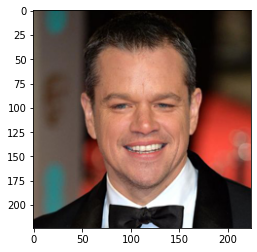

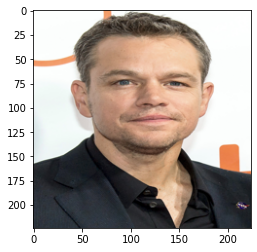

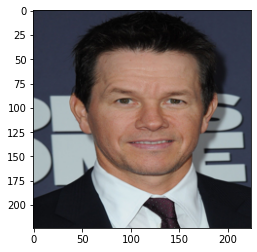

In [0]:
files = ['A.jpg','P.jpg','N.jpg']
use_img = []
for img_path in files:

    each_img = Image.open(img_path)

    each_img = np.array(each_img.resize((224,224)))/255.0

    img = each_img.astype(np.float32)

    show = plt.imshow( img )
    plt.show()
    use_img.append(img)


In [0]:
def get_diff(vec1,vec2):

    diff = tf.reduce_sum(tf.square(vec1-vec2))
    return diff.numpy()

In [0]:
vec_A = model( tf.expand_dims(use_img[0],0) )
vec_P = model( tf.expand_dims(use_img[1],0) )
vec_N = model( tf.expand_dims(use_img[2],0) )

A_and_P = get_diff(vec_A,vec_P)
A_and_N = get_diff(vec_A,vec_N)

print("difference b/w A and P ==> {}".format(A_and_P))
print("difference b/w A and N ==> {}".format(A_and_N))

"""
  Difference B/W A & P should be less than A & N , that what we trained the Network for.
  To tell the degree of difference b/w faces.

  Feel Free to Try other Confusing Images from Net.
  
  Congrats ! You have trained a very good Face Recognition Model. 
  You can use it for legit Practical purposes.
"""

difference b/w A and P ==> 16.191082000732422
difference b/w A and N ==> 26.701019287109375
